#### Imports

In [7]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix


from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


#### Fonctions utilitaires pour parcourir les images

In [8]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [9]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [10]:
grey_scale_limit = 10

def img_has_atleast_black_pixels(img, threshold = 5):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    return percent >= threshold

In [11]:
all_images = []
all_categories = []

max_ratio_threshold = 1.6
all_images_index_ratio = []

min_black_pixels_threshold = 5
all_images_indexes_black_pixels = []

all_images_index_ratio_and_black_pixels = []

datasetX = []
datasetY = []

image_size = (800, 800)

def load_datasets(img, category):
    new_img = cv2.resize(img, image_size)
    all_images.append(new_img)
    all_categories.append(category)

    if img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold):
        all_images_indexes_black_pixels.append(len(all_images)-1)

    if img_has_atleast_black_pixels(img, threshold=min_black_pixels_threshold) and img_is_in_ratio(img, max_ratio=max_ratio_threshold):
        all_images_index_ratio_and_black_pixels.append(len(all_images)-1)

    
browse_imgs(load_datasets)

def use_all_dataset():
    global datasetX, datasetY
    datasetX = np.array(all_images)
    datasetY = np.array(all_categories)
 
def use_ratio_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio])

def use_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_indexes_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_indexes_black_pixels])

def use_ratio_black_pixel_dataset():
    global datasetX, datasetY
    datasetX = np.array([all_images[i] for i in all_images_index_ratio_and_black_pixels])
    datasetY = np.array([all_categories[i] for i in all_images_index_ratio_and_black_pixels])

use_all_dataset()
print("Dataset all shape : ", datasetX.shape)
use_black_pixel_dataset()
print("Dataset bp shape : ", datasetX.shape)
use_ratio_dataset()
print("Dataset ration shape : ", datasetX.shape)
use_ratio_black_pixel_dataset()
print("Dataset bp+ratio shape : ", datasetX.shape)


Dataset all shape :  (5856, 800, 800)
Dataset bp shape :  (3178, 800, 800)
Dataset ration shape :  (4431, 800, 800)
Dataset bp+ratio shape :  (2502, 800, 800)


#### Cross validation

In [12]:
def cross_val(model, load_dataset_function, scoring, nb_folds=5):
    load_dataset_function()
    res = cross_validate(model, datasetX, datasetY, cv=nb_folds, scoring=scoring, error_score="raise", return_train_score=True)
    res.pop("fit_time")
    res.pop("score_time")
    return res
    

def fit_and_score_each_dataset(model, scoring):
    res = {}
    
    res["all"] = (cross_val(model, use_all_dataset, scoring))
    res["ratio"] = (cross_val(model, use_ratio_dataset, scoring))
    res["black_pixel"] = (cross_val(model, use_black_pixel_dataset, scoring))
    res["ratio_black_pixel"] = (cross_val(model, use_ratio_black_pixel_dataset, scoring))
    
    return res

#### Resize and Flatten Transformers

In [13]:
class ResizeImageTransformer():
    def __init__(self, size):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = np.array([cv2.resize(img, self.size) for img in X])
        return X

class FlattenTransformer():    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.reshape(len(X), -1)
        return X

#### Définition des différentes metrics

In [14]:
general_scoring = {
    "recall": make_scorer(recall_score, pos_label="PNEUMONIA"),
    "precision": make_scorer(precision_score, pos_label="PNEUMONIA"),
    "f1": make_scorer(f1_score, pos_label="PNEUMONIA")
}

#### Dummy Classifier

In [15]:
model = make_pipeline(
    FlattenTransformer(),
    DummyClassifier(strategy="most_frequent")
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
train_recall,"[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]"
test_precision,"[0.7295221843003413, 0.7292912040990607, 0.729...","[0.6617812852311161, 0.6613995485327314, 0.661...","[0.5943396226415094, 0.5943396226415094, 0.594...","[0.5109780439121756, 0.5109780439121756, 0.512..."
train_precision,"[0.7297181895815542, 0.7297758804695837, 0.729...","[0.6616817155756207, 0.6617771509167842, 0.661...","[0.5940204563335956, 0.5940204563335956, 0.594...","[0.511744127936032, 0.511744127936032, 0.51148..."
test_f1,"[0.8436112481499753, 0.8434567901234568, 0.843...","[0.7964721845318861, 0.7961956521739131, 0.796...","[0.7455621301775148, 0.7455621301775148, 0.745...","[0.6763540290620872, 0.6763540290620872, 0.677..."
train_f1,"[0.8437422858553444, 0.8437808489634748, 0.843...","[0.7964000679232467, 0.7964691902902733, 0.796...","[0.7453109575518263, 0.7453109575518263, 0.745...","[0.6770247933884298, 0.6770247933884298, 0.676..."


recall :  1.0
precision :  0.7440273037542662
f1score :  0.8532289628180039


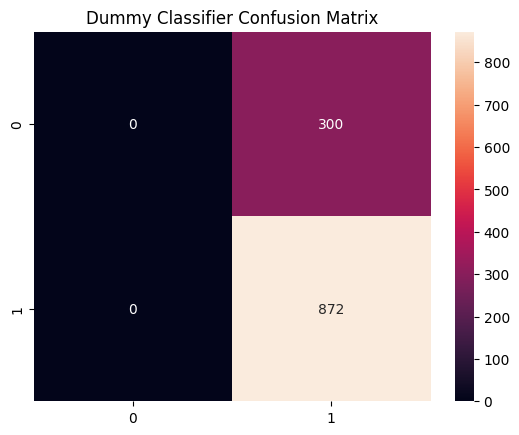

In [16]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Dummy Classifier Confusion Matrix")
plt.show()

#### KNeighborsClassifier

In [18]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=5)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[0.9719298245614035, 0.9754098360655737, 0.977...","[0.9522998296422487, 0.947098976109215, 0.9573...","[0.9470899470899471, 0.9497354497354498, 0.957...","[0.890625, 0.88671875, 0.90234375, 0.8359375, ..."
train_recall,"[0.9894675248683441, 0.9880081895291021, 0.986...","[0.9769722814498933, 0.9786871270247229, 0.972...","[0.971523178807947, 0.9735099337748344, 0.9649...","[0.935546875, 0.9453125, 0.9287109375, 0.93359..."
test_precision,"[0.9111842105263158, 0.9214601769911505, 0.920...","[0.9119086460032626, 0.9173553719008265, 0.910...","[0.8626506024096385, 0.8842364532019704, 0.902...","[0.8837209302325582, 0.8972332015810277, 0.898..."
train_precision,"[0.9324510614833196, 0.9328914664457332, 0.930...","[0.9294117647058824, 0.9314401622718053, 0.931...","[0.8939670932358318, 0.8941605839416058, 0.902...","[0.8978444236176195, 0.9063670411985019, 0.911..."
test_f1,"[0.9405772495755518, 0.9476678043230944, 0.948...","[0.9316666666666666, 0.9319899244332494, 0.933...","[0.9029003783102144, 0.9158163265306123, 0.929...","[0.8871595330739299, 0.8919449901768173, 0.900..."
train_f1,"[0.9601135557132718, 0.959659090909091, 0.9576...","[0.9525987525987526, 0.9544793182290584, 0.951...","[0.9311329736591558, 0.932149651236525, 0.9324...","[0.9163079866092778, 0.9254302103250478, 0.920..."


recall :  0.9793577981651376
precision :  0.9133689839572192
f1score :  0.945213060320974


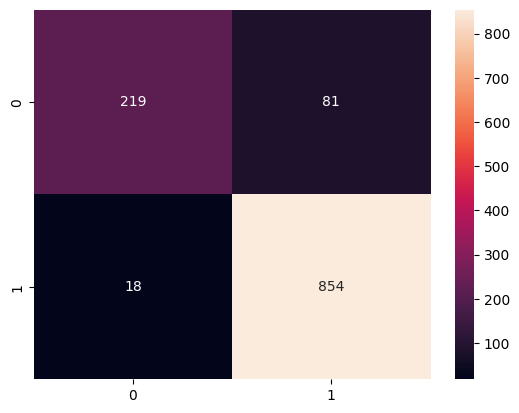

In [19]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### Affichage des différents params disponibles sur le modèle KNN

In [20]:
model.get_params()

{'memory': None,
 'steps': [('resizeimagetransformer',
   <__main__.ResizeImageTransformer at 0x1dd6a5f3da0>),
  ('flattentransformer', <__main__.FlattenTransformer at 0x1dd0af2aae0>),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'resizeimagetransformer': <__main__.ResizeImageTransformer at 0x1dd6a5f3da0>,
 'flattentransformer': <__main__.FlattenTransformer at 0x1dd0af2aae0>,
 'kneighborsclassifier': KNeighborsClassifier(),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

#### GridSearchCV pour le Recall Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors

In [ ]:
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 50, 2),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [ ]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(recall_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 49}

recall :  0.9885321100917431
precision :  0.8969823100936525
f1score :  0.9405346426623022


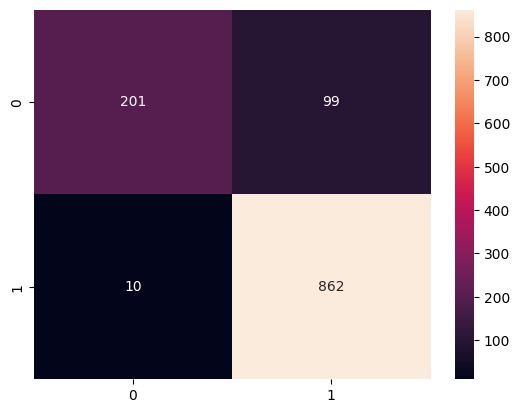

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le Precision Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors TO DO

In [22]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier()
)

param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 50, 2),
}

model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(precision_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 3}

recall :  0.9908256880733946
precision :  0.9515418502202643
f1score :  0.9707865168539326


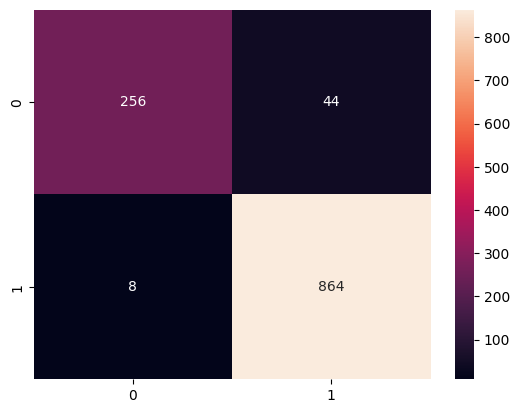

In [23]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors

In [ ]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(f1_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

{'kneighborsclassifier__n_neighbors': 11}

recall :  0.9896788990825688
precision :  0.9180851063829787
f1score :  0.9525386313465783


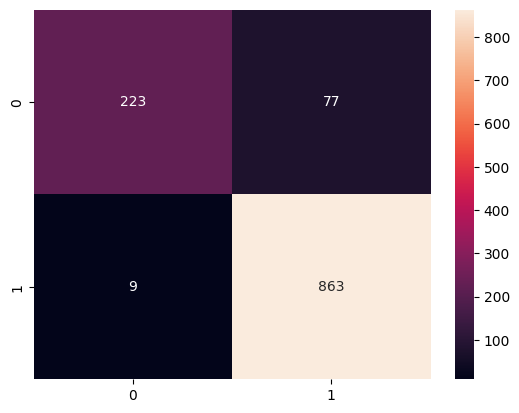

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=5)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__weights

In [ ]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11)
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

,all,ratio,black_pixel,ratio_black_pixel
test_recall,"[0.9836257309941521, 0.9836065573770492, 0.981...","[0.969335604770017, 0.9641638225255973, 0.9641...","[0.9576719576719577, 0.9603174603174603, 0.962...","[0.9140625, 0.90625, 0.9140625, 0.8671875, 0.9..."
train_recall,"[0.9888823873610298, 0.9880081895291021, 0.986...","[0.9752665245202559, 0.9782608695652174, 0.973...","[0.971523178807947, 0.9688741721854305, 0.9635...","[0.9208984375, 0.9345703125, 0.923828125, 0.92..."
test_precision,"[0.908207343412527, 0.9180327868852459, 0.9178...","[0.9104, 0.9216965742251223, 0.911290322580645...","[0.8743961352657005, 0.8832116788321168, 0.926...","[0.9105058365758755, 0.90625, 0.92490118577075..."
train_precision,"[0.9154929577464789, 0.9164405860010851, 0.913...","[0.9100676482292082, 0.9143426294820717, 0.916...","[0.8758208955223881, 0.875, 0.886654478976234,...","[0.890462700661001, 0.8994360902255639, 0.9087..."
test_f1,"[0.9444132509825941, 0.9496890898812889, 0.948...","[0.9389438943894389, 0.9424520433694745, 0.936...","[0.9141414141414141, 0.9201520912547528, 0.944...","[0.9122807017543859, 0.90625, 0.91944990176817..."
train_f1,"[0.9507735583684951, 0.9508796622097114, 0.948...","[0.9415397282832442, 0.9452224052718287, 0.944...","[0.921193092621664, 0.9195474544311754, 0.9235...","[0.9054248679788767, 0.9166666666666666, 0.916..."


In [ ]:
param_grid = {
    'kneighborsclassifier__weights': ['uniform', 'distance']
    # 'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [ ]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(f1_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

{'kneighborsclassifier__weights': 'uniform'}

recall :  0.9896788990825688
precision :  0.9180851063829787
f1score :  0.9525386313465783


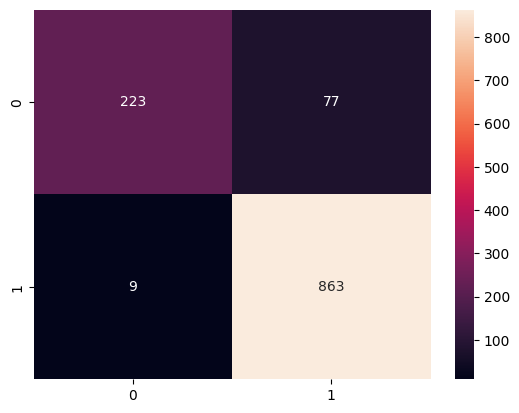

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__algorithm et kneighborsclassifier__weights

In [ ]:
param_grid = {
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [ ]:
model_grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=4, scoring=make_scorer(f1_score, pos_label="PNEUMONIA"))
use_all_dataset()
model_grid_search.fit(datasetX, datasetY)
model_grid_search.best_params_

In [ ]:
y_pred = model_grid_search.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### GridSearchCV pour le F1 Score -> Recherche du best paramètre pour kneighborsclassifier__n_neighbors, kneighborsclassifier__algorithm et kneighborsclassifier__weights TO DO

In [ ]:
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(1, 51, 2),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}


#### KNeighborsClassifier avec les 3 meilleurs paramètres identifiés par GridSearchCV TO DO

In [ ]:
model = make_pipeline(
    ResizeImageTransformer(size=(200,200)),
    FlattenTransformer(),
    KNeighborsClassifier(n_neighbors=11, weights='uniform', algorithm='')
)

scores = fit_and_score_each_dataset(model, general_scoring)
df = pd.DataFrame(scores)
df

In [ ]:
use_all_dataset()

trainx, testx, trainy, testy = train_test_split(datasetX, datasetY, test_size=0.2, random_state=1)
model.fit(trainx, trainy)

y_pred = model.predict(testx)
recall = recall_score(testy, y_pred, pos_label="PNEUMONIA")
precision = precision_score(testy, y_pred, pos_label="PNEUMONIA")
f1score = f1_score(testy, y_pred, pos_label="PNEUMONIA")
print("recall : ", recall)
print("precision : ", precision)
print("f1score : ", f1score)

cm = confusion_matrix(testy, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()